In [1]:
import os
import glob
import pandas as pd

# 6score 的根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,     # P1602N / P1602R / ...
                "class_name": class_name,  # 正常 / 異常 / 故障
                "label_idx": label_map[class_name],
            })

manifest = pd.DataFrame(rows)
print("總樣本數：", len(manifest))
display(manifest.head())

print("\n整體類別分布：")
print(manifest["class_name"].value_counts())


總樣本數： 4372


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



整體類別分布：
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

# 先做 manifest（跟之前一樣）
# manifest 需要有 device 和 class_name 兩欄

# 新增一個「分層 key」：設備 + 類別
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# 1) 先切出 train (75%) 和 temp (25%)
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],   # ← 用 strata 分層
    random_state=42,
)

# 2) 再把 temp 切成 val/test
# 想要：val = 10%, test = 15%  → 在 temp(25%) 裡：val: 0.4, test: 0.6
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,
    stratify=temp_df["strata"],    # ← 一樣用 strata 分層
    random_state=42,
)

# # 1) 第一刀：切出 Test (0.2) 和 Train_Val (0.8)
# train_val_df, test_df = train_test_split(
#     manifest,
#     test_size=0.2,               # 總體的 20% 給 Test
#     stratify=manifest["strata"], # 根據 strata 分層
#     random_state=42,
# )

# # 2) 第二刀：從 Train_Val (0.8) 中切出 Val (總體的 0.1)
# # 計算比例：想要 0.1 / 目前手上的 0.8 = 0.125
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.125,             # 0.125 * 0.8 = 0.1 (總體)
#     stratify=train_val_df["strata"],
#     random_state=42,
# )

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Total:     ", len(manifest))

print("\nTrain 類別分布：")
print(train_df["class_name"].value_counts())
print("\nVal 類別分布：")
print(val_df["class_name"].value_counts())
print("\nTest 類別分布：")
print(test_df["class_name"].value_counts())

print("\nTrain 設備分布：")
print(train_df["device"].value_counts())
print("\nVal 設備分布：")
print(val_df["device"].value_counts())
print("\nTest 設備分布：")
print(test_df["device"].value_counts())


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
Train size: 3279
Val size:   437
Test size:  656
Total:      4372

Train 類別分布：
class_name
正常    2416
異常     772
故障      91
Name: count, dtype: int64

Val 類別分布：
class_name
正常    322
異常    102
故障     13
Name: count, dtype: int64

Test 類別分布：
class_name
正常    484
異常    154
故障     18
Name: count, dtype: int64

Train 設備分布：
device
P1603N    653
P1604N    641
P1603R    636
P1604R    635
P1602N    359
P1602R    355
Name: count, dtype: int64

Val 設備分布：
device
P1603N    88
P1604N    86
P1603R    85
P1604R    84
P1602N    47
P1602R    47
Name: count, dtype: int64

Test 設備分布：
device
P1603N    131
P1604N    128
P1604R    127
P1603R    127
P1602N     72
P1602R     71
Name: c

正在載入 Scaler 和 模型...
✅ Scaler 載入成功


/tmp/ipykernel_4157661/1397308473.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/lo

✅ 模型參數載入成功
準備測試 656 筆資料...

✅ results_df created: (656, 9)

Classification Report (Re-loaded Model):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       484
           1       0.97      0.91      0.94       154
           2       0.94      0.94      0.94        18

    accuracy                           0.97       656
   macro avg       0.96      0.95      0.95       656
weighted avg       0.97      0.97      0.97       656



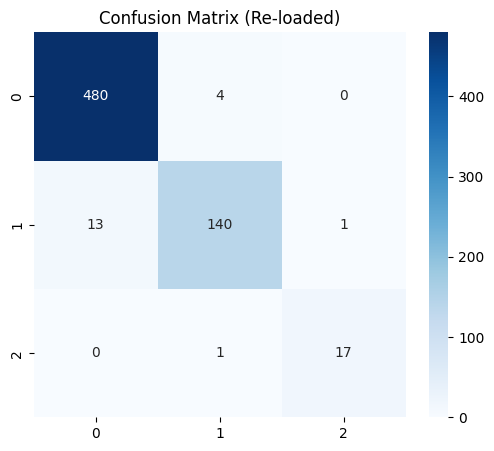

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib  # 用來載入 Scaler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 必須重新定義模型架構 (跟訓練時一模一樣)
# ==========================================
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed_input)
        last_hidden_state = h_n[-1]
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

# ==========================================
# 2. 設定參數 (必須跟訓練時一致)
# ==========================================
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS) # 12
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 3  # 正常0, 異常1, 故障2
DROPOUT = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 3. 載入 Scaler 和 模型
# ==========================================
print("正在載入 Scaler 和 模型...")

# (A) 載入 Scaler
try:
    scaler = joblib.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/LSTM/test1/scaler.pkl')
    print("✅ Scaler 載入成功")
except FileNotFoundError:
    print("❌ 找不到 scaler.pkl，請確認路徑！")
    exit()

# (B) 初始化模型並載入權重
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT).to(device)

try:
    model.load_state_dict(torch.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/LSTM/test1/best_lstm_model_test.pth', map_location=device))
    model.eval()  # 切換到評估模式 (關閉 Dropout)
    print("✅ 模型參數載入成功")
except FileNotFoundError:
    print("❌ 找不到 best_lstm_model.pth，請確認路徑！")
    exit()

# ==========================================
# 4. 準備測試資料 (這裡需要 Dataset Class)
# ==========================================
# 為了方便，這裡必須把 EventDataset 和 collate_fn 再貼一次
# (在實際專案中，通常會把這些 Class 寫在一個單獨的 data_utils.py 裡然後 import)

class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        # 如果是純預測(沒有標籤)，這裡可以設個假標籤，或者改寫 Dataset
        label = int(row["label_idx"]) 

        df = pd.read_csv(path)
        for c in self.cont_cols + self.bin_cat_cols:
            if c not in df.columns: df[c] = 0.0

        # 使用載入的 scaler 進行轉換
        if self.scaler is not None and not df[self.cont_cols].empty:
            df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

        feats = []
        for c in self.cont_cols:
            vals = df[c].values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))
        for c in self.bin_cat_cols:
            vals = df[c].fillna(0).astype(int).clip(0, 1).values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))
            
        features_tensor = torch.cat(feats, dim=1)
        return {
            "features": features_tensor,
            "length": features_tensor.shape[0],
            "label": torch.tensor(label, dtype=torch.long),
            "file_path": path,
            "device": row.get("device", None),
        }

def collate_fn(batch):
    batch = [item for item in batch if item["length"] > 0]
    if not batch: return {}
    features_list = [item["features"] for item in batch]
    lengths_list = [item["length"] for item in batch]
    labels_list = [item["label"] for item in batch]
    padded_features = pad_sequence(features_list, batch_first=True, padding_value=0.0)
    return {
        "features": padded_features,
        "lengths": torch.tensor(lengths_list, dtype=torch.long),
        "labels": torch.stack(labels_list),
        "file_paths": [item["file_path"] for item in batch],
        "devices": [item.get("device", None) for item in batch],
    }# ==========================================
# 5. 載入你的測試資料清單 (Manifest)
# ==========================================
# 假設你已經有 test_df (如果沒有，你需要像原本程式碼前段一樣讀取檔案列表)
# 這裡為了演示，假設 test_df 已經存在 (如果是新 session，你需要重新生成 test_df)

if 'test_df' not in locals():
    print("⚠ 注意：你需要重新生成 test_df (檔案清單)，才能進行測試。")
    # 這裡你可以貼上原本程式碼最前面「產生 manifest 和切分」的那段邏輯
else:
    print(f"準備測試 {len(test_df)} 筆資料...")
    test_dataset = EventDataset(test_df, CONT_COLS, BIN_CAT_COLS, scaler)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)

    # ==========================================
    # 6. 開始預測
    # ==========================================
    all_preds = []
    all_labels = []
    
    all_probs = []
    all_file_paths = []
    all_devices = []
    all_seq_lens = []

    with torch.no_grad():
        for batch in test_loader:
            if not batch:
                continue  # 跳過空 batch
            features = batch["features"].to(device)
            lengths = batch["lengths"]  # 保持在 CPU，forward 內會 lengths.cpu()
            labels = batch["labels"].to(device)

            outputs = model(features, lengths)
            probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

            all_preds.extend(predicted.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

            # 對齊每筆樣本的來源檔案/設備/序列長度，供後續 boundary analysis 使用
            fps = batch.get("file_paths", [None] * len(predicted))
            devs = batch.get("devices", [None] * len(predicted))
            all_file_paths.extend(list(fps))
            all_devices.extend(list(devs))
            all_seq_lens.extend(lengths.cpu().numpy().tolist())

    # 產生 results_df（後續 Boundary Case Analysis 會用到）
    all_probs = np.asarray(all_probs)
    results_df = pd.DataFrame({
        "file_path": all_file_paths,
        "device": all_devices,
        "true_label": np.asarray(all_labels, dtype=int),
        "pred_label": np.asarray(all_preds, dtype=int),
        "seq_len": np.asarray(all_seq_lens, dtype=int),
        "prob_normal": all_probs[:, 0] if all_probs.size else [],
        "prob_abnormal": all_probs[:, 1] if all_probs.size else [],
        "prob_fault": all_probs[:, 2] if all_probs.size else [],
    })
    if len(results_df) > 0:
        results_df["pred_conf"] = results_df[["prob_normal", "prob_abnormal", "prob_fault"]].max(axis=1)

    print(f"\n✅ results_df created: {results_df.shape}")

    # 顯示結果
    print("\nClassification Report (Re-loaded Model):")
    print(classification_report(all_labels, all_preds))

    # 畫混淆矩陣
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (Re-loaded)")
    plt.show()

In [4]:
# ==========================================================
# 7. Boundary Case Analysis (邊界案例分析) - 插入於推論流程之後
# 目標：
#   1) 自動從每個 CSV 抽取「健康分數」與「規則標籤」(若存在)
#   2) 找出健康分數靠近規則門檻 (theta0/theta1) 的樣本
#   3) 比較：規則(Hard label) vs 模型 Softmax 機率
#   4) 自動挑 1~3 個「規則判 Normal 但模型高信心判 Abnormal」的示範案例並畫圖
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- 7.1 你可調整的設定 --------------------
# (A) 健康分數欄位：留 None 會自動從 CSV 欄位中挑最常見的一個
HEALTH_SCORE_COL = None  # 例如: "four_formula_total" / "avg_score" / "score3"

# (B) 規則標籤欄位：留 None 會自動找 (health_category / rule_label ...)
RULE_LABEL_COL = None    # 例如: "health_category"

# (C) 規則門檻：你可以手動填；留 None 會根據 (rule_label, health_score) 的分佈自動估計
THETA0 = 80  # Normal/Abnormal 的門檻
THETA1 = 60  # Abnormal/Fault 的門檻

# (D) 邊界寬度 epsilon：建議用百分比 (例如 ±5%)
EPSILON_ABS = None
EPSILON_PCT = 0.05

# (E) 額外條件：挑案例時的模型信心門檻
MIN_MODEL_CONF = 0.70

# (F) 視覺化要畫的原始特徵欄位（依你的 CSV 欄位調整）
FEATURE_COLS = ["NCurrent", "RCurrent", "WRVT"]

# (G) 當 CSV 欄位名可能有空格/大小寫不一致時，會自動處理
HEALTH_SCORE_CANDIDATES = [
    "four_formula_total", "four_formula_total_avg",
    "avg_score",
    "calculated_health_score", "health_score", "healthscore",
    "score4", "score3", "score2", "score1",
    "score", "total_score"
]
RULE_LABEL_CANDIDATES = [
    "health_category", "rule_label", "calculated_rule_label", "label", "hard_label"
]

# LABEL_ZH = {0: "正常", 1: "異常", 2: "故障"}
# INV_LABEL_ZH = {v: k for k, v in LABEL_ZH.items()}

LABEL_EN = {0: "Normal", 1: "Abnormal", 2: "Fault"}


def _read_file_meta_one_row(file_path: str):
    """從單一 CSV 抽取：
    - health_score: 單一數值
    - rule_label: 0/1/2 (若存在)
    注意：只讀 nrows=1，速度快，也避免整檔讀取。"""
    try:
        df0 = pd.read_csv(file_path, nrows=1)
    except Exception:
        return np.nan, np.nan, None  # (health_score, rule_label, chosen_score_col)

    # 欄位名標準化：去空格、lower
    raw_cols = list(df0.columns)
    norm_cols = [str(c).strip() for c in raw_cols]
    df0.columns = norm_cols
    col_lut = {c.lower(): c for c in df0.columns}  # lower -> 原始(但strip後)欄位名

    # 找健康分數欄位
    chosen_score_col = None
    if HEALTH_SCORE_COL is not None:
        key = HEALTH_SCORE_COL.strip().lower()
        if key in col_lut:
            chosen_score_col = col_lut[key]
    else:
        for cand in HEALTH_SCORE_CANDIDATES:
            key = cand.lower()
            if key in col_lut:
                chosen_score_col = col_lut[key]
                break

    health_score = np.nan
    if chosen_score_col is not None:
        try:
            health_score = float(df0[chosen_score_col].iloc[0])
        except Exception:
            health_score = np.nan

    # 找規則標籤欄位
    chosen_rule_col = None
    if RULE_LABEL_COL is not None:
        key = RULE_LABEL_COL.strip().lower()
        if key in col_lut:
            chosen_rule_col = col_lut[key]
    else:
        for cand in RULE_LABEL_CANDIDATES:
            key = cand.lower()
            if key in col_lut:
                chosen_rule_col = col_lut[key]
                break

    rule_label = np.nan
    if chosen_rule_col is not None:
        try:
            rule_label = int(df0[chosen_rule_col].iloc[0])
        except Exception:
            rule_label = np.nan

    return health_score, rule_label, chosen_score_col

def _estimate_thresholds(df: pd.DataFrame, score_col="health_score", rule_col="rule_label"):
    """用資料自動估計 THETA0/THETA1（用中位數的中點法，對尺度/方向較穩）。"""
    sub = df.dropna(subset=[score_col, rule_col]).copy()
    if sub.empty:
        return None, None

    # 只保留 0/1/2
    sub = sub[sub[rule_col].isin([0, 1, 2])]
    if sub.empty:
        return None, None

    meds = sub.groupby(rule_col)[score_col].median().to_dict()
    # 如果缺類別，就無法估完整 2 個門檻
    if not all(k in meds for k in [0, 1, 2]):
        return None, None

    # 用 0-1 與 1-2 的 median 中點當門檻（不假設分數方向）
    theta0 = (meds[0] + meds[1]) / 2.0
    theta1 = (meds[1] + meds[2]) / 2.0
    return float(theta0), float(theta1)


ℹ results_df 沒有 health_score 欄位，將從 CSV 內抽取（每檔讀 nrows=1）
✅ health_score 抽取完成，NaN 比例：0.000
count    656.000000
mean      86.745134
std       14.134073
min        0.000000
1%        20.690765
5%        67.550803
25%       79.382031
50%       89.631318
75%       97.291667
95%      100.000000
99%      100.000000
max      100.000000
Name: health_score, dtype: float64
rule_label 分佈（含 NaN）：
rule_label
0    484
1    154
2     18
Name: count, dtype: int64
✅ 邊界樣本數量：147 (THETA0±4.0000, THETA1±3.0000)
                                            file_path  health_score  \
11  /home/t113ab8043/Desktop/nanten_railway_code/資...     79.393401   
12  /home/t113ab8043/Desktop/nanten_railway_code/資...     77.613559   
15  /home/t113ab8043/Desktop/nanten_railway_code/資...     78.538506   
16  /home/t113ab8043/Desktop/nanten_railway_code/資...     76.283577   
24  /home/t113ab8043/Desktop/nanten_railway_code/資...     76.517466   
25  /home/t113ab8043/Desktop/nanten_railway_code/資...     77.662800   
27  /home

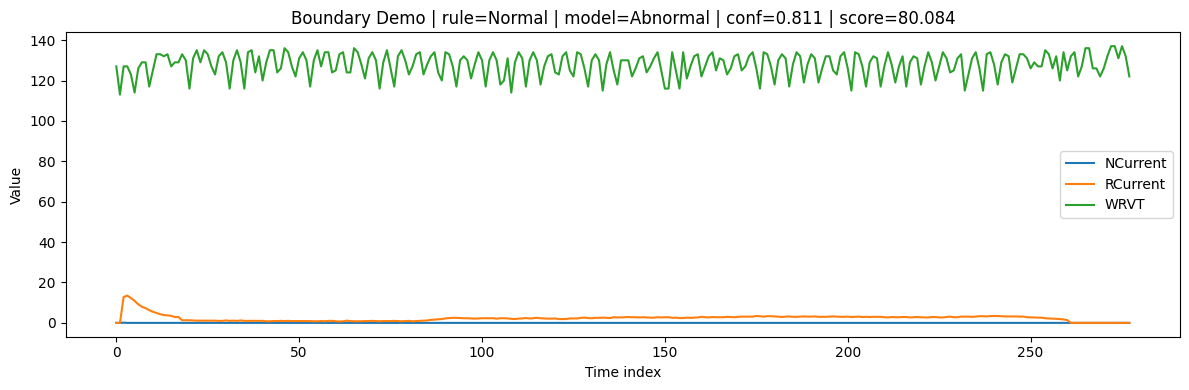

Model softmax probabilities: Normal=0.188, Abnormal=0.811, Fault=0.001

✅ Demo transition: Abnormal->Normal | conf= 0.971 | score= 78.984
Demo file: /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602N/異常/P1602N_20230514033946_1.csv


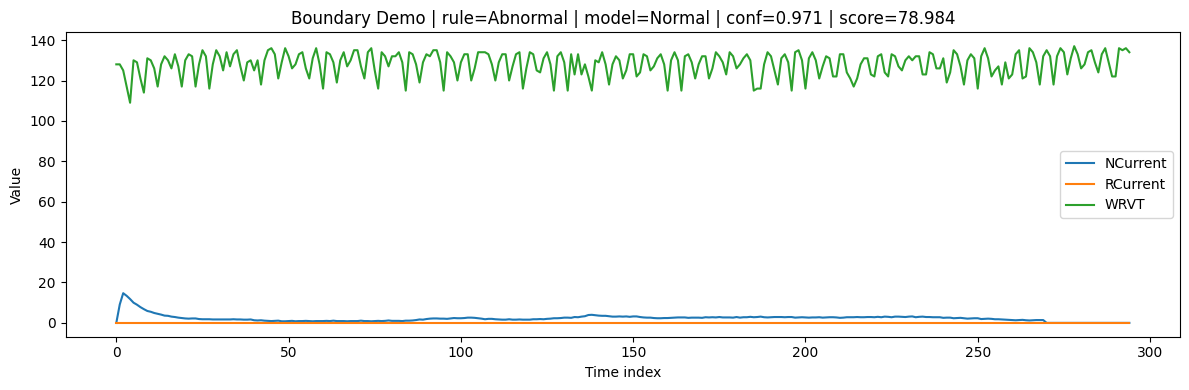

Model softmax probabilities: Normal=0.971, Abnormal=0.024, Fault=0.005

✅ Demo transition: Abnormal->Fault | conf= 0.721 | score= 60.716
Demo file: /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230302045422_1.csv


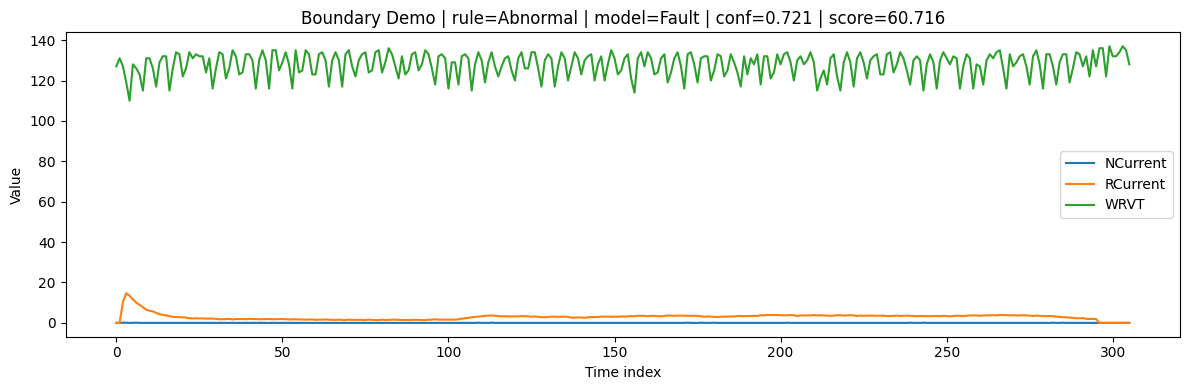

Model softmax probabilities: Normal=0.002, Abnormal=0.277, Fault=0.721

✅ Demo transition: Fault->Abnormal | conf= 0.982 | score= 59.345
Demo file: /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602N/故障/P1602N_20230409050731_2.csv


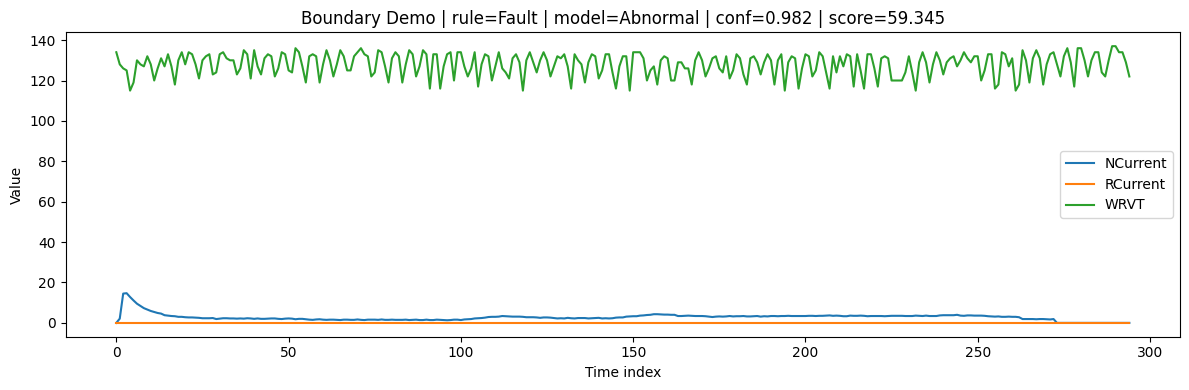

Model softmax probabilities: Normal=0.006, Abnormal=0.982, Fault=0.012
⚠ boundary_df 為空：請確認健康分數欄位存在、以及門檻 THETA0/THETA1 與 epsilon 設定。


In [5]:
# -------------------- 7.2 取得 health_score / rule_label --------------------
if "results_df" not in globals():
    print("❌ 找不到 results_df，請先執行推論 cell（產生 results_df）")
else:
    # 若 results_df 沒有 health_score，就從 CSV 抽取
    if "health_score" not in results_df.columns:
        print("ℹ results_df 沒有 health_score 欄位，將從 CSV 內抽取（每檔讀 nrows=1）")
        hs_list, rl_list, sc_col_list = [], [], []
        for fp in results_df["file_path"].tolist():
            hs, rl, sc_col = _read_file_meta_one_row(fp)
            hs_list.append(hs)
            rl_list.append(rl)
            sc_col_list.append(sc_col)
        results_df["health_score"] = hs_list
        results_df["rule_label"] = rl_list
        results_df["health_score_col_used"] = sc_col_list
    else:
        # 若已存在 health_score，但 rule_label 不存在，也嘗試補上
        if "rule_label" not in results_df.columns:
            print("ℹ results_df 沒有 rule_label 欄位，將從 CSV 內抽取（每檔讀 nrows=1）")
            rl_list = []
            for fp in results_df["file_path"].tolist():
                _, rl, _ = _read_file_meta_one_row(fp)
                rl_list.append(rl)
            results_df["rule_label"] = rl_list

    # Debug: 看看 health_score 抽取狀況
    if "health_score" in results_df.columns:
        nan_ratio = float(results_df["health_score"].isna().mean())
        print(f"✅ health_score 抽取完成，NaN 比例：{nan_ratio:.3f}")
        print(results_df["health_score"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

    # Debug: rule_label
    if "rule_label" in results_df.columns:
        print("rule_label 分佈（含 NaN）：")
        print(results_df["rule_label"].value_counts(dropna=False))

    # -------------------- 7.3 自動估計 THETA0/THETA1（若未手動填） --------------------
    theta0, theta1 = THETA0, THETA1
    if theta0 is None or theta1 is None:
        est0, est1 = _estimate_thresholds(results_df, score_col="health_score", rule_col="rule_label")
        if est0 is not None and est1 is not None:
            theta0, theta1 = est0, est1
            print(f"✅ 自動估計門檻：THETA0={theta0:.4f}, THETA1={theta1:.4f}")
        else:
            print("⚠ 無法自動估計門檻（可能缺少 rule_label 或 health_score 全是 NaN）")

    # -------------------- 7.4 建立邊界樣本 boundary_df --------------------
    boundary_df = results_df.copy()

    # epsilon 計算
    if EPSILON_PCT is not None:
        eps0 = abs(theta0) * EPSILON_PCT if theta0 is not None else None
        eps1 = abs(theta1) * EPSILON_PCT if theta1 is not None else None
    else:
        eps0 = EPSILON_ABS
        eps1 = EPSILON_ABS

    # 若門檻不可用，直接提示
    if theta0 is None or theta1 is None or eps0 is None or eps1 is None:
        boundary_df = boundary_df.iloc[0:0]
        print("⚠ boundary_df 為空：請確認 health_score / rule_label 是否存在，以及 THETA0/THETA1 是否可取得。")
    else:
        boundary_df["near_theta0"] = (boundary_df["health_score"] - theta0).abs() <= eps0
        boundary_df["near_theta1"] = (boundary_df["health_score"] - theta1).abs() <= eps1
        boundary_df["near_threshold"] = boundary_df["near_theta0"] | boundary_df["near_theta1"]
        boundary_df = boundary_df[boundary_df["near_threshold"]].copy()

        print(f"✅ 邊界樣本數量：{len(boundary_df)} (THETA0±{eps0:.4f}, THETA1±{eps1:.4f})")

    # -------------------- 7.5 規則 vs 模型：建立 mismatch_type（向量化，空DF也安全） --------------------
    if not boundary_df.empty:
        # 用 rule_label 當規則標籤；若 rule_label 是 NaN，就退回用 true_label（資料夾標籤）
        boundary_df["hard_label"] = boundary_df["rule_label"]
        mask_nan_rule = boundary_df["hard_label"].isna()
        if mask_nan_rule.any() and "true_label" in boundary_df.columns:
            boundary_df.loc[mask_nan_rule, "hard_label"] = boundary_df.loc[mask_nan_rule, "true_label"]

        boundary_df["hard_label"] = boundary_df["hard_label"].astype(int)
        boundary_df["hard_label_en"] = boundary_df["hard_label"].map(LABEL_EN)
        boundary_df["pred_label_en"] = boundary_df["pred_label"].map(LABEL_EN)


        boundary_df["mismatch_type"] = "match"
        mm = boundary_df["hard_label"] != boundary_df["pred_label"]
        boundary_df.loc[mm, "mismatch_type"] = (
            boundary_df.loc[mm, "hard_label_en"].astype(str) + "->" + boundary_df.loc[mm, "pred_label_en"].astype(str)
        )

        # 顯示前幾筆
        show_cols = ["file_path","health_score","hard_label_en","pred_label_en","pred_conf","prob_normal","prob_abnormal","prob_fault","seq_len","mismatch_type"]
        print(boundary_df[show_cols].head(20))

        
# -------------------- 7.6 邊界子集：規則 vs 模型 的錯誤型態統計 --------------------
# (a) 以數字標籤統計各類型 (0/1/2)
_mm = boundary_df["hard_label"] != boundary_df["pred_label"]
_trans_counts = boundary_df.loc[_mm].groupby(["hard_label", "pred_label"]).size()

def _N(a, b):
    """Count of transition a->b within boundary subset (mismatches only)."""
    return int(_trans_counts.get((a, b), 0))

print("\n📌 Boundary subset disagreement counts (rule → model):")
print(
    f"  N0→1={_N(0,1)}, N1→0={_N(1,0)}, "
    f"N1→2={_N(1,2)}, N2→1={_N(2,1)}, "
    f"N0→2={_N(0,2)}, N2→0={_N(2,0)}"
)

# (b) 英文類別的交叉表（更好貼到論文/報告）
try:
    _ct = pd.crosstab(boundary_df["hard_label_en"], boundary_df["pred_label_en"], dropna=False)
    print("\n📌 Boundary subset confusion (rule rows vs model cols):")
    print(_ct)
except Exception as _e:
    print("⚠ 無法印出英文交叉表（可能缺少 hard_label_en/pred_label_en）：", _e)

# -------------------- 7.7 自動挑示範案例（支援多種錯誤型態） --------------------
# 你可以把想看的錯誤型態放在這裡，例如：
#   (0,1) Normal->Abnormal
#   (1,0) Abnormal->Normal
#   (1,2) Abnormal->Fault
#   (2,1) Fault->Abnormal
DEMO_TRANSITIONS = [(0,1), (1,0), (1,2), (2,1)]
TOPK_PER_TRANSITION = 1   # 每一種錯誤型態要畫幾筆（建議 1~2）
MAX_DEMOS_TOTAL = 6       # 全部最多畫幾張（避免太多圖）
REQUIRE_MIN_CONF = True   # True: 只挑 pred_conf >= MIN_MODEL_CONF；False: 不限制

demo_plotted = 0

for (a, b) in DEMO_TRANSITIONS:
    if demo_plotted >= MAX_DEMOS_TOTAL:
        break

    sub = boundary_df[
        (boundary_df["hard_label"] == a) &
        (boundary_df["pred_label"] == b)
    ].copy()

    if sub.empty:
        print(f"⚠ 沒有找到邊界子集中 {a}->{b} 的樣本。")
        continue

    # 套用信心門檻（若開啟）
    if REQUIRE_MIN_CONF:
        sub_hi = sub[sub["pred_conf"] >= MIN_MODEL_CONF].copy()
        if sub_hi.empty:
            print(f"⚠ {a}->{b} 沒有 pred_conf >= {MIN_MODEL_CONF:.2f} 的樣本，將改用最高信心的案例示範。")
            sub_hi = sub.copy()
    else:
        sub_hi = sub.copy()

    sub_hi = sub_hi.sort_values("pred_conf", ascending=False)

    # 逐筆畫圖
    for _, row in sub_hi.head(TOPK_PER_TRANSITION).iterrows():
        if demo_plotted >= MAX_DEMOS_TOTAL:
            break

        demo_fp = row["file_path"]
        print("\n✅ Demo transition:", f"{row.get('hard_label_en', a)}->{row.get('pred_label_en', b)}",
            "| conf=", f"{row['pred_conf']:.3f}",
            "| score=", f"{row['health_score']:.3f}")
        print("Demo file:", demo_fp)

        # 讀整檔畫圖
        try:
            df_full = pd.read_csv(demo_fp)
        except Exception as _e:
            print("⚠ 無法讀取 demo CSV：", _e)
            continue

        df_full.columns = [str(c).strip() for c in df_full.columns]
        cols_to_plot = [c for c in FEATURE_COLS if c in df_full.columns]

        if not cols_to_plot:
            print("⚠ CSV 內找不到 FEATURE_COLS，請確認欄位名：", df_full.columns.tolist()[:30], "...")
        else:
            plt.figure(figsize=(12, 4))
            for c in cols_to_plot:
                plt.plot(df_full[c].values, label=c)

            plt.title(
                f"Boundary Demo | rule={row.get('hard_label_en', a)} | model={row.get('pred_label_en', b)} "
                f"| conf={row['pred_conf']:.3f} | score={row['health_score']:.3f}"
            )
            plt.xlabel("Time index")
            plt.ylabel("Value")
            plt.legend()
            plt.tight_layout()
            plt.show()

            print("Model softmax probabilities:",
                f"Normal={row.get('prob_normal', float('nan')):.3f},",
                f"Abnormal={row.get('prob_abnormal', float('nan')):.3f},",
                f"Fault={row.get('prob_fault', float('nan')):.3f}")

        demo_plotted += 1

if demo_plotted == 0:
    print("⚠ 沒有成功繪製任何 demo。你可以：")
    print("  - 放寬 MIN_MODEL_CONF (例如 0.5)")
    print("  - 放寬 EPSILON_PCT (例如 0.10)")
    print("  - 或把 REQUIRE_MIN_CONF 改成 False")
else:
    print("⚠ boundary_df 為空：請確認健康分數欄位存在、以及門檻 THETA0/THETA1 與 epsilon 設定。")


✅ 成功載入訓練紀錄 (history.pkl)


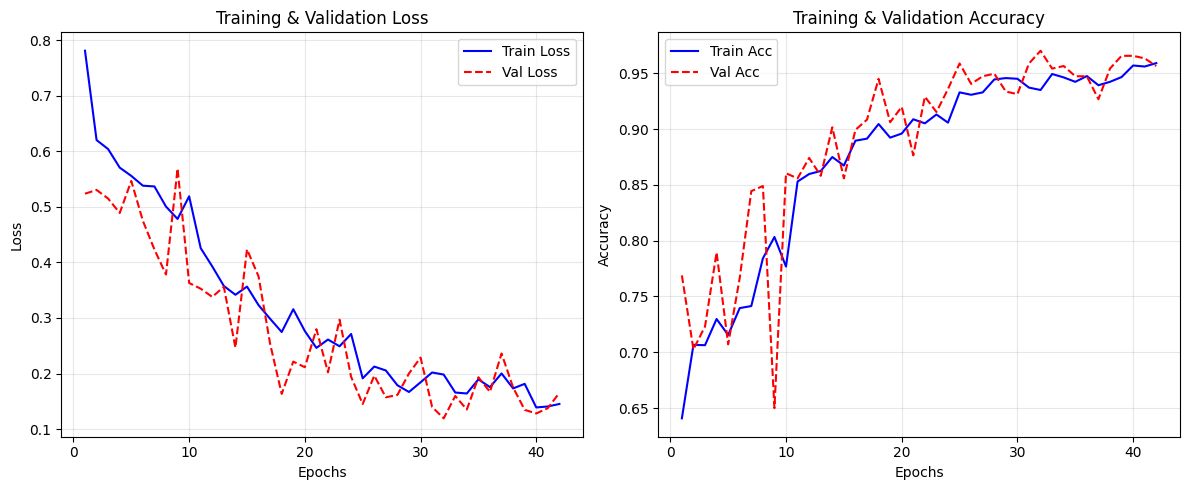

In [7]:
import matplotlib.pyplot as plt
import joblib

# 1. 載入訓練紀錄
try:
    history = joblib.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/history.pkl')
    print("✅ 成功載入訓練紀錄 (history.pkl)")
except FileNotFoundError:
    print("❌ 找不到 history.pkl，請確認是否有執行過訓練並存檔。")
    # 為了避免程式報錯，這裡做個假資料 (實際使用時會被 exit 擋下)
    history = None
    exit()

# 2. 開始畫圖
if history:
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # ---- Loss Curve ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label="Train Loss")
    plt.plot(epochs, history["val_loss"],   'r--', label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- Accuracy Curve ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'b-', label="Train Acc")
    plt.plot(epochs, history["val_acc"],   'r--', label="Val Acc")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [6]:
# ==========================================================
# 8. XAI (Captum Integrated Gradients) for Boundary Cases  ✅完整版（穩定可跑版）
# - 針對 boundary_df 內的錯判樣本，用 Integrated Gradients (IG)
# - 產生「Raw 波形 + (time × feature) attribution heatmap」圖
# - 為了避免 cuDNN LSTM backward 限制：IG 一律在 CPU 上跑
# ==========================================================

import os
import copy
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ---- Captum ----
try:
    from captum.attr import IntegratedGradients
except Exception as e:
    raise ImportError("❌ 無法 import captum。請先安裝：pip install captum 或 conda install -c conda-forge captum") from e


# =========================
# 8.1 參數設定
# =========================
XAI_OUTDIR = "./xai_ig_figs1"
os.makedirs(XAI_OUTDIR, exist_ok=True)

TOPK_PER_TRANSITION = 3   # 每種 mismatch_type 最多輸出幾張（可改）
IG_STEPS = 50             # IG steps（越大越穩但越慢）
USE_ZERO_BASELINE = True  # StandardScaler 後 mean ≈ 0，baseline 用 0 合理

# 上圖要畫的 raw waveforms（可改）
PLOT_CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]

# 如果你想固定 random（通常IG不靠random，但保險）
torch.manual_seed(0)
np.random.seed(0)


# =========================
# 8.2 基本檢查
# =========================
required_globals = ["boundary_df", "model", "CONT_COLS", "BIN_CAT_COLS"]
missing = [k for k in required_globals if k not in globals()]
if missing:
    raise RuntimeError(f"❌ 缺少必要變數：{missing}\n請先跑完 Boundary Case Analysis，並確保 model/CONT_COLS/BIN_CAT_COLS 已存在。")

if boundary_df is None or len(boundary_df) == 0:
    raise RuntimeError("❌ boundary_df 為空。請先跑完 Boundary Case Analysis。")

# scaler 可為 None（看你原本 pipeline）
if "scaler" not in globals():
    scaler = None

# boundary_df 欄位檢查（少了就先報出來）
need_cols = [
    "mismatch_type","file_path","hard_label","pred_label","pred_conf","health_score",
    "hard_label_en","pred_label_en","prob_normal","prob_abnormal","prob_fault"
]
missing_cols = [c for c in need_cols if c not in boundary_df.columns]
if missing_cols:
    raise RuntimeError(f"❌ boundary_df 缺少欄位：{missing_cols}\n請確認你 boundary analysis 的輸出欄位一致。")


# =========================
# 8.3 選案例：每種 mismatch_type 取 pred_conf TopK
# =========================
xai_df = boundary_df[boundary_df["mismatch_type"] != "match"].copy()
if len(xai_df) == 0:
    raise RuntimeError("⚠ boundary_df 裡沒有 mismatch（全部 match），因此沒有可做 XAI 的案例。")

xai_df = (
    xai_df.sort_values("pred_conf", ascending=False)
          .groupby("mismatch_type", as_index=False, group_keys=False)
          .head(TOPK_PER_TRANSITION)
)

print("✅ XAI 將輸出下列案例（每種 mismatch_type 取 Top conf）")
print(xai_df[["mismatch_type","health_score","hard_label_en","pred_label_en","pred_conf","file_path"]].to_string(index=False))


# =========================
# 8.4 單檔讀取 + 轉成 model input (1, L, F)
# =========================
def load_one_sample_for_model(file_path: str, cont_cols, bin_cat_cols, scaler):
    df = pd.read_csv(file_path)
    df.columns = [str(c).strip() for c in df.columns]

    # 缺欄補 0
    for c in cont_cols + bin_cat_cols:
        if c not in df.columns:
            df[c] = 0.0

    # raw 用於畫圖（未標準化）
    raw_df = df.copy()

    # 連續特徵：強制轉 numeric->float32，再做 scaler.transform，避免 pandas dtype FutureWarning
    if scaler is not None and len(df) > 0:
        df.loc[:, cont_cols] = (
            df.loc[:, cont_cols]
              .apply(pd.to_numeric, errors="coerce")
              .fillna(0.0)
              .astype(np.float32)
        )
        df.loc[:, cont_cols] = scaler.transform(df.loc[:, cont_cols]).astype(np.float32)
    else:
        # 沒 scaler 就至少保證 float32
        df.loc[:, cont_cols] = (
            df.loc[:, cont_cols]
              .apply(pd.to_numeric, errors="coerce")
              .fillna(0.0)
              .astype(np.float32)
        )

    feats = []

    # cont (float32)
    for c in cont_cols:
        vals = df[c].values.astype(np.float32)
        feats.append(torch.from_numpy(vals).unsqueeze(1))  # (L,1)

    # bin/cat (0/1 float32)
    for c in bin_cat_cols:
        vals = (df[c].fillna(0).astype(int).clip(0, 1).values.astype(np.float32))
        feats.append(torch.from_numpy(vals).unsqueeze(1))  # (L,1)

    x = torch.cat(feats, dim=1)   # (L, F)
    L = x.shape[0]
    x = x.unsqueeze(0)            # (1, L, F)
    lengths = torch.tensor([L], dtype=torch.long)

    return raw_df, x, lengths


# =========================
# 8.5 IG 計算 + 畫圖（穩定版：CPU 上跑 IG）
# =========================
def safe_forward_logits(model_cpu, x_in, lengths_cpu):
    """
    兼容不同 forward 介面：
    - model(x, lengths)
    - model(x)
    並兼容回傳 (logits, ...) 的情況
    """
    try:
        out = model_cpu(x_in, lengths_cpu)
    except TypeError:
        out = model_cpu(x_in)

    # 若回傳 tuple/list，取第一個當 logits
    if isinstance(out, (tuple, list)):
        out = out[0]
    return out


def ig_for_one_case(
    model,
    raw_df,
    x,
    lengths,
    target_class: int,
    out_png: str,
    cont_cols,
    title_extra: str = ""
):
    # 1) 用 deepcopy 建 CPU 模型，避免動到你原本 GPU model 狀態
    model_cpu = copy.deepcopy(model).to("cpu")
    model_cpu.eval()

    # 2) inputs / baseline / lengths 都在 CPU
    x_cpu = x.detach().to("cpu").float().requires_grad_(True)
    baseline = torch.zeros_like(x_cpu) if USE_ZERO_BASELINE else torch.zeros_like(x_cpu)
    lengths_cpu = lengths.detach().to("cpu")

    # 3) Captum 只吃 inputs，因此 lengths 用 closure 固定
    def forward_fn(x_in):
        logits = safe_forward_logits(model_cpu, x_in, lengths_cpu)
        return logits

    ig = IntegratedGradients(forward_fn)

    # 4) 計算 attribution
    attr = ig.attribute(
        x_cpu,
        baselines=baseline,
        target=int(target_class),
        n_steps=int(IG_STEPS)
    )  # (1,L,F)

    attr = attr.detach().cpu().numpy()[0]   # (L,F)
    attr_abs = np.abs(attr)

    # 只取連續特徵的 attribution 做 heatmap
    F_cont = len(cont_cols)
    heat = attr_abs[:, :F_cont].T  # (F_cont, L)
    time_score = heat.sum(axis=0)  # (L,)

    # 5) 畫圖
    fig = plt.figure(figsize=(12, 6))

    # (a) Raw waveform
    ax1 = fig.add_subplot(2, 1, 1)
    plotted = 0
    for c in PLOT_CONT_COLS:
        if c in raw_df.columns:
            ax1.plot(raw_df[c].values, label=c)
            plotted += 1
    ax1.set_ylabel("Signal value")
    ax1.set_title("Current waveform (raw)")
    if plotted > 0:
        ax1.legend(loc="upper right")

    # (b) IG Heatmap
    ax2 = fig.add_subplot(2, 1, 2)
    im = ax2.imshow(heat, aspect="auto", interpolation="nearest")
    ax2.set_yticks(range(F_cont))
    ax2.set_yticklabels(cont_cols)
    ax2.set_xlabel("Time index")
    ax2.set_title("Integrated Gradients attribution (abs) | " + title_extra)
    fig.colorbar(im, ax=ax2, fraction=0.02, pad=0.01)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close(fig)

    # 6) summary
    top_idx = np.argsort(time_score)[::-1][:10].tolist()
    return {
        "top_time_idx": top_idx,
        "top_time_score": time_score[top_idx].tolist(),
        "time_score_sum": float(time_score.sum()),
        "seq_len": int(x_cpu.shape[1]),
    }


# =========================
# 8.6 逐案例輸出圖 + 匯出 summary CSV
# =========================
xai_records = []

for _, r in xai_df.iterrows():
    fp = r["file_path"]
    hard = int(r["hard_label"])
    pred = int(r["pred_label"])
    conf = float(r["pred_conf"])
    score = float(r["health_score"])
    trans = str(r["mismatch_type"])

    raw_df, x, lengths = load_one_sample_for_model(fp, CONT_COLS, BIN_CAT_COLS, scaler)

    # 用「模型預測類別」當 target：解釋模型為何偏向這個類別
    target_class = pred

    out_png = os.path.join(
        XAI_OUTDIR,
        f"IG_{trans.replace('->','to')}_conf{conf:.3f}_score{score:.2f}.png"
    )

    title_extra = f"rule={r['hard_label_en']} | model={r['pred_label_en']} | conf={conf:.3f} | score={score:.2f}"

    summ = ig_for_one_case(
        model=model,
        raw_df=raw_df,
        x=x,
        lengths=lengths,
        target_class=target_class,
        out_png=out_png,
        cont_cols=CONT_COLS,
        title_extra=title_extra
    )

    rec = {
        "mismatch_type": trans,
        "file_path": fp,
        "health_score": score,
        "rule_label": hard,
        "pred_label": pred,
        "pred_conf": conf,
        "prob_normal": float(r["prob_normal"]),
        "prob_abnormal": float(r["prob_abnormal"]),
        "prob_fault": float(r["prob_fault"]),
        **summ,
        "xai_png": out_png,
    }
    xai_records.append(rec)

    print("✅ saved:", out_png)

xai_summary_df = pd.DataFrame(xai_records)
out_csv = os.path.join(XAI_OUTDIR, "xai_ig_summary.csv")
xai_summary_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("✅ XAI summary CSV:", out_csv)

print("\n✅ Done. 你現在應該會在 ./xai_ig_figs/ 看到 PNG 圖 + xai_ig_summary.csv")


✅ XAI 將輸出下列案例（每種 mismatch_type 取 Top conf）
   mismatch_type  health_score hard_label_en pred_label_en  pred_conf                                                                                           file_path
 Fault->Abnormal     59.344789         Fault      Abnormal   0.981840 /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602N/故障/P1602N_20230409050731_2.csv
Abnormal->Normal     78.984197      Abnormal        Normal   0.971107 /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602N/異常/P1602N_20230514033946_1.csv
Abnormal->Normal     77.673409      Abnormal        Normal   0.952603 /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1603N/異常/P1603N_20230320033750_1.csv
Abnormal->Normal     78.811085      Abnormal        Normal   0.944422 /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1603R/異常/P1603R_20230515215434_1.csv
Normal->Abnormal     80.084075        Normal      Abnormal   0.811182 /home/t113ab8043/Desktop/nanten_railw

/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0

✅ saved: ./xai_ig_figs1/IG_FaulttoAbnormal_conf0.982_score59.34.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0

✅ saved: ./xai_ig_figs1/IG_AbnormaltoNormal_conf0.971_score78.98.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0

✅ saved: ./xai_ig_figs1/IG_AbnormaltoNormal_conf0.953_score77.67.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023 -0.57812023
 -0.57812023 -0.57812023 -0.57812023 

✅ saved: ./xai_ig_figs1/IG_AbnormaltoNormal_conf0.944_score78.81.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.28982317 -2.7425804  -0.28982317 -0.28982317 -0.99061096 -2.5673835
 -0.46502012  0.06057073  0.06057073 -2.0417926  -0.64021707  0.76135856
  0.76135856  0.5861616   0.76135856 -0.28982317  0.06057073  0.06057073
  0.76135856  0.23576768 -2.2169895   0.41096464  1.1117524   0.06057073
  1.1117524   0.76135856 -0.28982317 -0.99061096  0.5861616   0.9365555
  0.06057073 -2.2169895   0.23576768  1.1117524   0.06057073 -2.2169895
  0.9365555   1.1117524  -0.815414    0.5861616  -1.5162019   0.06057073
  1.1117524   1.1117524  -0.815414   -0.46502012  1.2869494   0.9365555
 -0.28982317 -1.165808    0.41096464  0.9365555   0.23576768 -2.0417926
  0.23576768  1.1117524  -0.28982317  0.9365555   0.9365555  -0.815414
 -0.64021707  0.76135856  0.9365555  -0.815414   -0.815414    1.2869494
  0.9365555  -0.11462622 -1.3410048   0.41096

✅ saved: ./xai_ig_figs1/IG_NormaltoAbnormal_conf0.811_score80.08.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089 -0.6035089
 -0.6035089 -0.6035089 -0.6035089 -0

✅ saved: ./xai_ig_figs1/IG_NormaltoAbnormal_conf0.794_score82.91.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.5861616  -0.11462622 -1.8665957  -3.2681713  -0.28982317  0.06057073
 -1.165808   -2.5673835   0.23576768  0.23576768 -0.28982317 -2.0417926
  0.06057073  0.5861616   0.41096464 -1.5162019  -0.64021707  0.5861616
  0.5861616   0.5861616  -0.815414   -0.99061096  0.5861616   0.76135856
  0.23576768 -2.2169895   0.5861616   0.9365555   0.41096464 -2.0417926
  0.5861616   0.9365555   0.23576768 -1.3410048   0.06057073  0.76135856
  0.5861616   0.76135856  1.1117524   0.41096464 -1.8665957   0.41096464
  1.1117524   0.41096464 -0.99061096  0.41096464  0.76135856  0.5861616
 -0.64021707 -0.99061096  0.76135856 -0.99061096  0.23576768  1.2869494
  0.5861616  -0.99061096  0.06057073  0.76135856  0.76135856 -0.28982317
 -1.165808    0.5861616   1.1117524   0.76135856  1.1117524   0.76135856
  0.41096464 -0.46502012  0.76135856  0.93

✅ saved: ./xai_ig_figs1/IG_NormaltoAbnormal_conf0.731_score81.06.png


/tmp/ipykernel_4157661/3751008784.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.28982317  0.41096464 -0.28982317 -1.6913987  -3.2681713  -0.11462622
 -0.46502012 -0.99061096 -2.3921866   0.41096464  0.41096464 -0.46502012
 -2.0417926   0.06057073  0.5861616   0.5861616  -2.3921866  -0.46502012
  0.9365555   0.76135856 -1.165808   -0.46502012  0.9365555   0.41096464
  0.76135856  0.5861616   0.5861616  -0.815414    0.41096464 -2.2169895
 -0.46502012  0.9365555   0.76135856 -1.3410048  -0.46502012  1.1117524
  0.5861616  -0.99061096 -0.815414    0.76135856  0.76135856  0.23576768
 -2.2169895   0.23576768  1.1117524   0.23576768 -2.2169895   1.1117524
  1.1117524  -0.64021707  0.06057073  0.9365555  -0.11462622 -2.2169895
  1.1117524  -0.815414   -0.64021707  1.1117524   0.76135856 -0.99061096
 -0.99061096  0.76135856  0.9365555   0.23576768 -2.0417926   0.23576768
  0.9365555   0.23576768 -2.0417926   0.7

✅ saved: ./xai_ig_figs1/IG_AbnormaltoFault_conf0.721_score60.72.png
✅ XAI summary CSV: ./xai_ig_figs1/xai_ig_summary.csv

✅ Done. 你現在應該會在 ./xai_ig_figs/ 看到 PNG 圖 + xai_ig_summary.csv
